In [1]:
import numpy as np
import pandas as pd
import gzip
import csv
import os
import torch
import torch.nn as nn

np.set_printoptions(precision=2)
np.random.seed(123)

In [2]:
# generate a dictionary of data grouped by sequenceID
def gen_data_dict(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)

    _dict = tuple(df.groupby('sequenceID'))
    return _dict

# # test
# seqs   = gen_data_dict('sequence_label_data/signals.gz')
# labels = gen_data_dict('sequence_label_data/labels.gz')

In [3]:
def get_data(i, seqs, labels):
    # sequence
    sequence = seqs[i][1]['logratio'].to_numpy()
    sequence = np.append([0], sequence)

    # labels
    lab_df = labels[i][1]

    # get label sets
    lab_df_1, lab_df_2 = lab_df[lab_df['fold'] == 1], lab_df[lab_df['fold'] == 2]

    pos_lab_df_1, pos_lab_df_2 = lab_df_1[lab_df_1['changes'] == 1], lab_df_2[lab_df_2['changes'] == 1]
    neg_lab_df_1, neg_lab_df_2 = lab_df_1[lab_df_1['changes'] == 0], lab_df_2[lab_df_2['changes'] == 0]

    neg_start_1, neg_end_1 = neg_lab_df_1['start'].to_numpy(), neg_lab_df_1['end'].to_numpy()
    pos_start_1, pos_end_1 = pos_lab_df_1['start'].to_numpy(), pos_lab_df_1['end'].to_numpy()
    neg_start_2, neg_end_2 = neg_lab_df_2['start'].to_numpy(), neg_lab_df_2['end'].to_numpy()
    pos_start_2, pos_end_2 = pos_lab_df_2['start'].to_numpy(), pos_lab_df_2['end'].to_numpy()

    return sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, neg_start_2, neg_end_2, pos_start_2, pos_end_2

# # test
# seq_id = 186
# sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, neg_start_2, neg_end_2, pos_start_2, pos_end_2 = get_data(seq_id, seqs, labels)
# print("sequence:    ", sequence[0:5])
# print("neg start 1: ", neg_start_1)
# print("neg end 1    ", neg_end_1)
# print("pos start 1: ", pos_start_1)
# print("pos end 1:   ", pos_end_1)
# print("neg start 2: ", neg_start_2)
# print("neg end 2    ", neg_end_2)
# print("pos start 2: ", pos_start_2)
# print("pos end 2:   ", pos_end_2)

In [4]:
# generate toy data: sequence, labels
def gen_toy_data():

    # Generate a sequence with 10 numbers
    sequence_length = 10
    sequence = np.zeros(sequence_length + 1)

    means = [5, 2]                # Define the means for the 4 segments
    segment_lengths = [5, 5]      # Define the lengths of the segments

    # Populate the sequence with segments having different means
    start_index = 1
    for mean, length in zip(means, segment_lengths):
        end_index = start_index + length
        sequence[start_index:end_index] = np.random.normal(loc=mean, scale=0.2, size=length)
        start_index = end_index

    # outlier
    sequence[8] = 8

    # Labels
    neg_start = [2, 7]      # there is no changepoint at point 2, 7, and 8
    neg_end   = [3, 9]      #
    pos_start = [4]         # there can be exactly one changepoint at 4 or 5
    pos_end   = [6]         #

    return sequence, neg_start, neg_end, pos_start, pos_end

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()
# print("sequence:  ", toy_sequence)
# print("neg start: ", neg_start)
# print("neg end    ", neg_end)
# print("pos start: ", pos_start)
# print("pos end:   ", pos_end)

In [5]:
# Get cumulative sum vectors
def get_cumsum(sequence):
    y = np.cumsum(sequence)
    z = np.cumsum(np.square(sequence))

    y = np.append([0], y)
    z = np.append([0], z)

    return y, z

# # test
# y, z = get_cumsum(toy_sequence)
# print("cumsum vector:", y)
# print("cumsum square:", z)

In [6]:
# function to create loss value from 'start' to 'end' given cumulative sum vector y (data) and z (square)
def L(start, end, y, z):
    _y = y[end+1] - y[start]
    _z = z[end+1] - z[start]
    return _z - np.square(_y)/(end-start+1)
    

# # test
# y, z = get_cumsum(toy_sequence)
# print("sequence    : ", toy_sequence)
# print("from 1 to 1 : ", L(1, 1,  y, z))
# print("from 1 to 2 : ", L(1, 2,  y, z))
# print("from 5 to 6 : ", L(5, 6,  y, z))
# print("from 1 to 10: ", L(1, 10, y, z))

In [7]:
# function to get the list of changepoint from vector tau_star
def trace_back(tau_star):
    tau = tau_star[-1]
    chpnt = np.array([len(tau_star)], dtype=int)
    while tau > 0:
        chpnt = np.append(tau, chpnt)
        tau = tau_star[tau-1]
    return np.append(0, chpnt)

# # test
# print(trace_back(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])))
# print(trace_back(np.array([0, 0, 0, 0, 0, 5, 5, 5, 5, 5])))

In [8]:
# counting errors
def error_count(chpnt, neg_start, neg_end, pos_start, pos_end):
    chpnt = chpnt[1:]
    
    fp = 0
    fn = 0
    tp = 0
    tn = 0

    for ns, ne in zip(neg_start, neg_end):
        count = sum(1 for cp in chpnt if ns <= cp < ne)
        if count >= 1:
            fp += 1
        else:
            tn += 1

    for ps, pe in zip(pos_start, pos_end):
        count = sum(1 for cp in chpnt if ps <= cp < pe)
        if count >= 2:
            fp += 1
        elif count == 0:
            fn += 1
        else:
            tp += 1

    return fp, fn, tp, tn

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()
# print("neg start: ", neg_start)
# print("neg end    ", neg_end)
# print("pos start: ", pos_start)
# print("pos end:   ", pos_end)

# chpnt = [0, 3, 5, 6, 9, 10]
# print(chpnt, "   :", 
# (chpnt, neg_start, neg_end, pos_start, pos_end))

# chpnt = [0, 1, 2, 6, 8, 9, 10]
# print(chpnt, ":",error_count(chpnt, neg_start, neg_end, pos_start, pos_end))

In [9]:
# function to write a row into a csv file
def write_to_csv(filename, header, row):
    # Check if the file exists
    file_exists = os.path.isfile(filename)

    # Open the CSV file in write mode
    with open(filename, 'a', newline='') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # If the file is newly created, write the header row
        if not file_exists:
            csv_writer.writerow(header)

        # Write the new row
        csv_writer.writerow(row)

In [10]:
# OPART given lambda and sequence
def opart(lda, sequence):

    # cumsum vector:
    y, z = get_cumsum(sequence)

    # length of sequence
    sequence_length = len(sequence)-1

    # Set up
    C = np.zeros(sequence_length + 1)
    C[0] = -lda

    # Get tau_star
    tau_star = np.zeros(sequence_length+1, dtype=int)
    for t in range(1, sequence_length+1):

        # get set of possible value
        V = C[:t] + lda + L(1 + np.arange(t), t, y, z)

        # get optimal tau from set V
        last_chpnt = np.argmin(V)

        # update C_i
        C[t] = V[last_chpnt]

        # update tau_star
        tau_star[t] = last_chpnt

    # get set of changepoints
    set_of_chpnt = trace_back(tau_star[1:])

    return set_of_chpnt

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()
# sequence_length = len(toy_sequence) - 1
# for lda in [0, 10, 100]:
#     print("lambda = %4d: %s" % (lda, opart(lda, toy_sequence)))

In [11]:
def get_T(t, neg_start, neg_end, pos_start, pos_end): 

    # if t is just outside of pos region
    for s, e in zip(pos_start, pos_end):
        if(t == e):
            T = np.arange(s, e)
            return T
    
    # initiate T = [0, ..., t]
    T = np.arange(t)
    
    # remove negative regions
    for s, e in zip(neg_start, neg_end):
        T = T[(T < s) | (T >= e)]
    
    # remove positive regions with t > end and t > start
    for s, e in zip(pos_start, pos_end):
        if(t < e):
            T = T[(T < s)]
        else:
            T = T[(T >= s)]
    
    return T

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()

# for t in range(11):
#     print(get_T(t, neg_start, neg_end, pos_start, pos_end))

In [12]:
# lopart dynamic algorithm return set of changepoints given lambda, T (set of possible changepoints), sequence, and cumsum vectors
def lopart(sequence, neg_start, neg_end, pos_start, pos_end, lda):
    # cumsum vector
    y, z = get_cumsum(sequence)
    
    # sequence length
    sequence_length = len(sequence)-1

    # Set up
    C = np.zeros(sequence_length + 1)
    C[0] = -lda

    # Get tau_star
    tau_star = np.zeros(sequence_length+1, dtype=int)
    for t in range(1, sequence_length+1):

        # get set of possible changepoint
        po_chpnt = get_T(t, neg_start, neg_end, pos_start, pos_end)

        # get set of possible value
        # V = np.inf * np.ones(sequence_length+1)
        # for j in po_chpnt:
        #     V[j] = C[j] + lda + L(j+1, t, y, z)
        V = C[po_chpnt] + lda + L(1 + po_chpnt, t, y, z)
        
        # get optimal tau from set V
        last_chpnt = po_chpnt[np.argmin(V)]

        # update C_i
        C[t] = V[np.argmin(V)]

        # update tau_star
        tau_star[t] = last_chpnt

    # get set of changepoints
    set_of_chpnt = trace_back(tau_star[1:])

    return set_of_chpnt

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()
# sequence_length = len(toy_sequence) - 1
# y, z = get_cumsum(toy_sequence)
# for lda in [0, 1, 10]:
#     print("lambda = %4d: %s" % (lda, lopart(toy_sequence, neg_start, neg_end, pos_start, pos_end, lda)))

In [13]:
# function to get the mean vector of the sequence from the list of changepoint
def get_mean(y, chpnt):
    mean = np.zeros(len(y)-1)
    for i in range(len(chpnt)-1):
        mean[chpnt[i]+1:chpnt[i+1]+1] = (y[chpnt[i+1]+1] - y[chpnt[i]+1])/(chpnt[i+1] - chpnt[i])
    return mean

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()
# y, z = get_cumsum(toy_sequence)
# chpnt = lopart(toy_sequence, neg_start, neg_end, pos_start, pos_end, lda=0)
# print(get_mean(y, chpnt))

In [14]:
# function to plot sequence with labels and changepoints wrt lambda (if provided)
from plotnine import *

def plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end, algorithm='LOPART', chpnt=None, lda=None):
    y = get_cumsum(sequence)[0]
    sequence = sequence[1:]

    # Prepare data for plotnine
    data = pd.DataFrame({'point': range(1, len(sequence)+1), 'value': sequence})

    # Create the plot
    plot = (
        ggplot(data, aes(x='point', y='value')) +
        theme_minimal() +
        labs(x='point', y='value') +
        xlim(0, len(sequence) + 1) +
        ylim(np.min(sequence) - 1, np.max(sequence) + 1)
    )

    # Add negative regions
    for start, end in zip(neg_start, neg_end):
        plot += geom_rect(aes(xmin=start, xmax=end, ymin=np.min(sequence) - 1, ymax=np.max(sequence) + 1),
                          fill='pink', alpha=0.2, color='black', size=0)

    # Add positive regions
    for start, end in zip(pos_start, pos_end):
        plot += geom_rect(aes(xmin=start, xmax=end, ymin=np.min(sequence) - 1, ymax=np.max(sequence) + 1),
                          fill='red', alpha=0.2, color='black', size=0)

    # Add data points
    plot += geom_point(color='blue', size=2, alpha=0.7)
    
    # Add changepoint
    if chpnt is not None:
        for i in range(1, len(chpnt)-1):
            plot += geom_vline(xintercept=chpnt[i]+0.5, linetype='dashed', color='deepskyblue', alpha=0.8)  

        mean = get_mean(y, chpnt)[1:]
        for i in range(len(chpnt) - 1):
            plot += geom_segment(aes(x=chpnt[i]+0.5, y=mean[chpnt[i]], xend=chpnt[i+1]+0.5, yend=mean[chpnt[i]]),
                            color='green', size=1, alpha=0.7)

    # Set the figure title
    if lda is not None:
        plot += ggtitle(algorithm + ' -- lambda = ' + str(lda) + ' -- errors = ' + str(sum(error_count(chpnt, neg_start, neg_end, pos_start, pos_end))))

    # Center the title horizontally
        plot += theme(plot_title=element_text(hjust=0.5))

    # Add legend
    plot += labs(color="Legend")  # Legend title
    plot += guides(color=guide_legend(title="Legend"))  # Legend label

    # return the plot
    return plot

# # test
# toy_sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()

# for lda in [0, 1]:
#     chpnt = lopart(toy_sequence, neg_start, neg_end, pos_start, pos_end, lda)
#     print(plot_sequence(toy_sequence, neg_start, neg_end, pos_start, pos_end, 'LOPART', chpnt, lda))

In [15]:
# Custom loss function
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=1, low_lim=-7, high_lim=7):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin
        self.low_lim  = low_lim
        self.high_lim = high_lim

    def forward(self, predicted, y):
        low, high = y[:, 0], y[:, 1]
        margin = self.margin
        loss_low = torch.relu(low - predicted + margin) * torch.sign(low - self.low_lim)
        loss_high = torch.relu(predicted - high + margin) * torch.sign(self.high_lim - high)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss), dtype=torch.float)

In [16]:
def show_error_rate(df):
    fold1_total_errs = df['fold_1_fp_errs'].sum() + df['fold_1_fn_errs'].sum()
    fold2_total_errs = df['fold_2_fp_errs'].sum() + df['fold_2_fn_errs'].sum()

    fold1_total_labels = df['fold_1_total_labels'].sum()
    fold2_total_labels = df['fold_2_total_labels'].sum()

    rate1 = 100*(fold1_total_labels - fold1_total_errs)/fold1_total_labels
    rate2 = 100*(fold2_total_labels - fold2_total_errs)/fold2_total_labels

    # print("fold1.test: %5.2f \t fold2.test: %5.2f \t total_label_fold1: %3d \t total_label_fold2: %3d \t total_test_error_fold1: %3d \t total_test_error_fold2: %3d" 
    #       % (rate1, rate2, fold1_total_labels, fold2_total_labels, fold1_total_errs, fold2_total_errs))

    return rate1, rate2, fold1_total_labels, fold2_total_labels, fold1_total_errs, fold2_total_errs

In [ ]:
import matplotlib.pyplot as plt

def plot_section(low_target, high_target, feature, section_color='blue', low_color='blue', high_color='green'):
    plt.scatter([low_target], [feature], color=low_color, s=50, label='Low Target')
    plt.scatter([high_target], [feature], color=high_color, s=50, label='High Target')
    plt.plot([low_target, high_target], [feature, feature], color=section_color, linestyle='-', linewidth=0.5, label='Section')


def plot_feature_targets(feature, low_target, high_target, predicted_target, feature_name):

    # Plotting each section
    for i in range(len(low_target)):
        plot_section(low_target[i], high_target[i], feature[i])

    # plot predicted target
    if(predicted_target is not None):
        plt.plot(predicted_target, feature, color='red', marker='o')

    # Adding labels and title
    plt.xlabel('Log(Lambda)')
    plt.ylabel('Feature')
    plt.title(f'Feature: {feature_name}')

    # Show the plot
    plt.show()

106.5
0.03877420783172201
[0, 1, 2, 23, 25, 61, 162, 163, 250, 256]


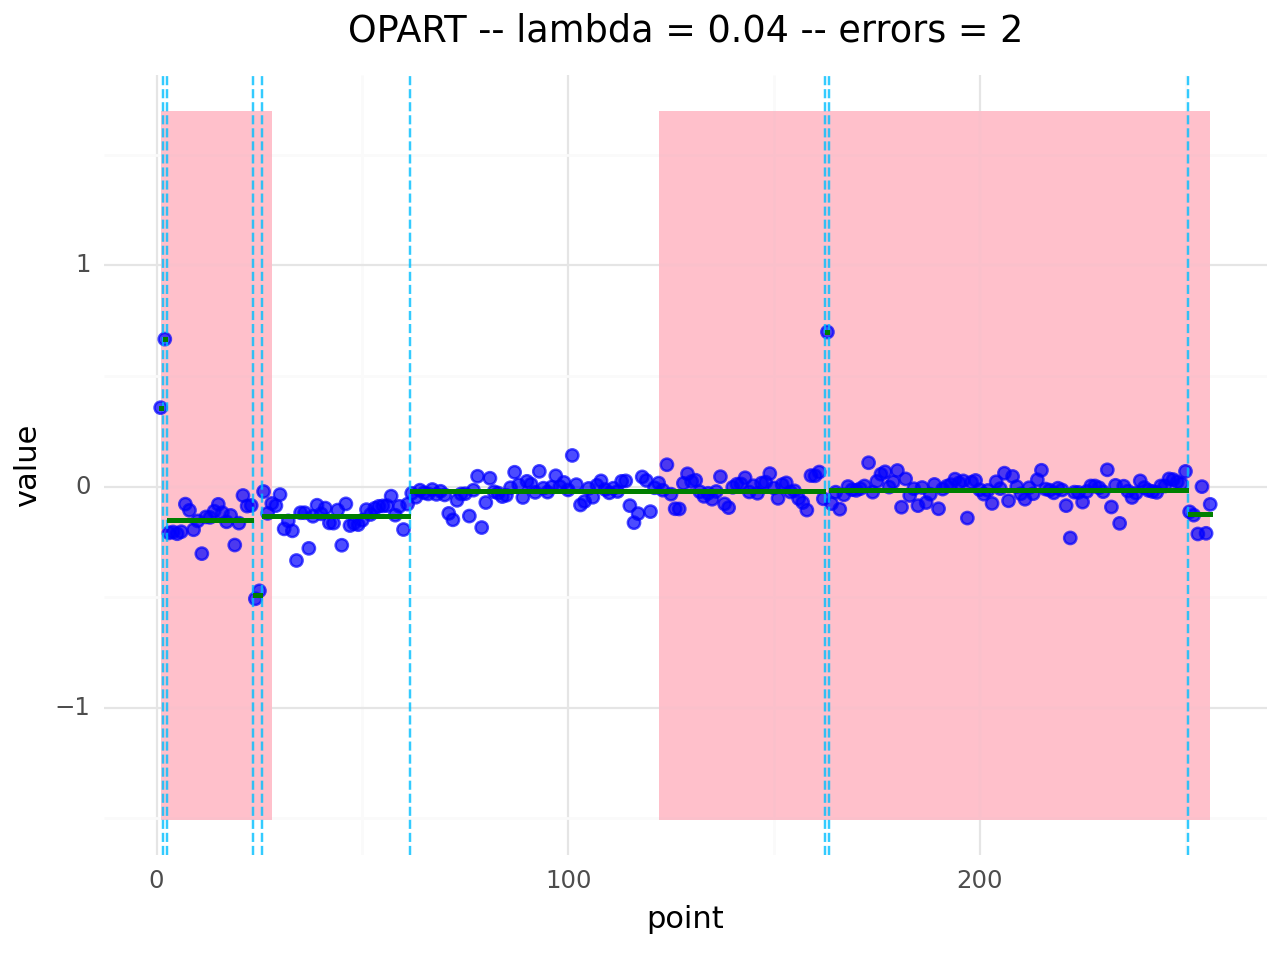

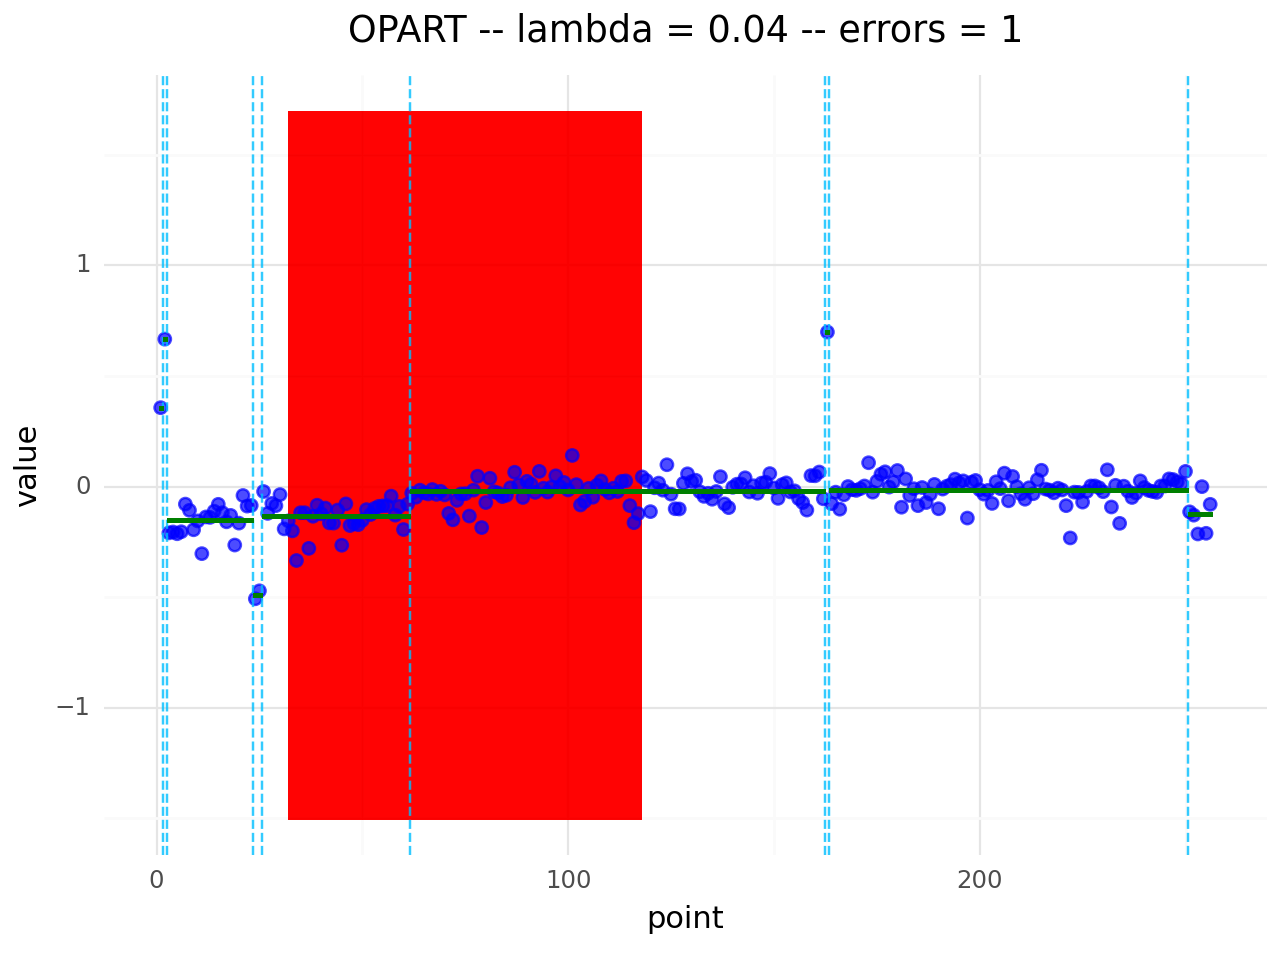

In [36]:
# seqs   = gen_data_dict('../1_genome/0_sequences_labels/signals.gz')
# labels = gen_data_dict('../1_genome/0_sequences_labels/labels.gz')

# i = 7
# print(seqs[i][0])

# sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, neg_start_2, neg_end_2, pos_start_2, pos_end_2 = get_data(i, seqs, labels)
# lda = np.exp(-3.25)
# chpnt = opart(lda, sequence)
# print(lda)
# print(list(chpnt))
# print(plot_sequence(sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, algorithm='OPART', chpnt=chpnt, lda=np.round(lda, 2)))
# print(plot_sequence(sequence, neg_start_2, neg_end_2, pos_start_2, pos_end_2, algorithm='OPART', chpnt=chpnt, lda=np.round(lda, 2)))